In [75]:
import torch
from torch_geometric.nn.models import InnerProductDecoder
import numpy as np
from torch.nn import Parameter as Param, Linear
from torch import nn
from torch_geometric.nn.conv import GATv2Conv, MessagePassing
import torch.nn.functional as F
from torch_geometric.data import Data

import pickle
from sklearn import metrics

torch.manual_seed(29)
np.random.seed(29)
EPS = 1e-13

## Custom defined functions

In [76]:
def auprc_auroc_ap(target_tensor, score_tensor):
    y = target_tensor.detach().cpu().numpy()
    pred = score_tensor.detach().cpu().numpy()
    auroc, ap = metrics.roc_auc_score(y, pred), metrics.average_precision_score(y, pred)
    y, xx, _ = metrics.precision_recall_curve(y, pred)
    auprc = metrics.auc(xx, y)

    return auprc, auroc, ap

def get_range_list(edge_list):
    tmp = []
    s = 0
    for i in edge_list:
        tmp.append((s, s + i.shape[1]))
        s += i.shape[1]
    return torch.tensor(tmp)

def negative_sampling(pos_edge_index, num_nodes, num_dis):

    idx = (pos_edge_index[0] * num_nodes + pos_edge_index[1])
    idx = idx.to(torch.device('cpu'))

    perm = torch.tensor(np.random.choice(num_nodes*num_dis, idx.size(0)))
    mask = torch.from_numpy(np.isin(perm, idx).astype(np.uint8))
    rest = mask.nonzero().view(-1)

    while rest.numel() > 0:
        tmp = torch.tensor(np.random.choice(num_nodes*num_dis, rest.size(0)))
        mask = torch.from_numpy(np.isin(tmp, idx).astype(np.uint8))
        perm[rest] = tmp
        rest = mask.nonzero().view(-1)
    row, col = perm / num_nodes, perm % num_nodes
    returnable = torch.stack([row, col], dim=0).long().to(pos_edge_index.device)
    return returnable

def typed_negative_sampling(pos_edge_index, num_nodes, num_dis, range_list):
    
    tmp = []
    for start, end in range_list:
        tmp.append(negative_sampling(pos_edge_index[:, start: end], num_nodes, num_dis))
        
    value = torch.cat(tmp, dim=1)
    return value

def process_edges(raw_edge_list, p=0.9):
    train_list = []
    test_list = []
    train_label_list = []
    test_label_list = []

    train_mask = np.random.binomial(1, p, raw_edge_list.shape[1])
    test_mask = 1 - train_mask
    train_set = train_mask.nonzero()[0]
    test_set = test_mask.nonzero()[0]

    train_list.append(raw_edge_list[:, train_set])
    test_list.append(raw_edge_list[:, test_set])

    train_label_list.append(torch.ones(2 * train_set.size, dtype=torch.long))
    test_label_list.append(torch.ones(2 * test_set.size, dtype=torch.long))

    train_range = get_range_list(train_list)
    test_range = get_range_list(test_list)

    train_edge_idx = torch.cat(train_list, dim=1)
    test_edge_idx = torch.cat(test_list, dim=1)

    train_et = torch.cat(train_label_list)
    test_et = torch.cat(test_label_list)
    
    return train_edge_idx, train_et, train_range, test_edge_idx, test_et, test_range

## Custom Graph Convolution For Cross Edge

In [77]:
class CrossEdgeConv(MessagePassing):

    def __init__(self, in_dim, out_dim,
                 unique_source_num, unique_target_num,
                 is_after_relu=True, is_bias=False, **kwargs):

        super(CrossEdgeConv, self).__init__(aggr='mean', **kwargs)

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.unique_source_num = unique_source_num
        self.unique_target_num = unique_target_num
        self.is_after_relu = is_after_relu

        self.weight = Param(torch.Tensor(in_dim, out_dim))

        if is_bias:
            self.bias = Param(torch.Tensor(out_dim))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        if self.is_after_relu:
            self.weight.data.normal_(std=1/np.sqrt(self.in_dim))
        else:
            self.weight.data.normal_(std=2/np.sqrt(self.in_dim))

        if self.bias:
            self.bias.data.zero_()

    def forward(self, x, edge_index, range_list):
        return self.propagate(edge_index, x=x, range_list=range_list)

    def message(self, x_j):
        return x_j

    def update(self, aggr_out, range_list):
        if self.bias:
            aggr_out += self.bias

        out = torch.matmul(aggr_out[self.unique_source_num:, :], self.weight)
        assert out.shape[0] == self.unique_target_num

        return out

    def __repr__(self):
        return '{}({}, {}'.format(self.__class__.__name__, self.in_dim, self.out_dim)

## Integrated GAE

In [78]:
class Setting(object):
    def __init__(self, sp_rate=0.9, lr=0.01, prot_drug_dim=16, prot_dis_dim = 16, n_drug_embed=64,
                n_dis_embed=64, n_hid1=32, n_hid2=16) -> None:
        super().__init__()
        self.sp_rate = sp_rate
        self.lr = lr
        self.prot_drug_dim = prot_drug_dim
        self.prot_dis_dim = prot_dis_dim
        self.n_drug_embed = n_drug_embed
        self.n_dis_embed = n_dis_embed
        self.n_hid1 = n_hid1
        self.n_hid2 = n_hid2

In [112]:
class DrugDiseaseGNN(torch.nn.Module):
    def __init__(self, settings:Setting, device, mod='cat', data_path='./final_data.pkl', ) -> None:
        super().__init__()
        self.mod = mod
        self.device = device
        self.settings = settings
        self.data = self.__prepare_data(data_path, settings.sp_rate).to(device)
        self.__prepare_model()


    def __prepare_data(self, data_path, sp_rate):

        with open(data_path, 'rb') as f:
            data_dict = pickle.load(f)
        data = Data.from_dict(data_dict)
        
        data.dd_train_idx, data.dd_train_et, data.dd_train_range, data.dd_test_idx, data.dd_test_et, data.dd_test_range = process_edges(data.dd_edge_index, p=sp_rate)
        self.test_neg_index = typed_negative_sampling(data.dd_test_idx, data.n_drug, data.n_dis, data.dd_test_range)

        return data

    def __get_ndata__(self):
        return self.data.n_drug_feat, self.data.n_drug, self.data.p_feat.shape[1], self.data.n_prot, self.data.n_dis_feat, self.data.n_dis

    def __get_dimset__(self):
        return self.settings.prot_drug_dim, self.settings.prot_dis_dim, self.settings.n_drug_embed, self.settings.n_dis_embed,self.settings.n_hid1, self.settings.n_hid2

    def __prepare_model(self):

        # encoder

        self.encoder = EndToEndEncoder(
            self.device,
            *self.__get_ndata__(), 
            *self.__get_dimset__()
        ).to(self.device)

        # decoder
        
#         self.decoder = MultiInnerProductDecoder(
#             self.settings.n_hid2
#         ).to(self.device)
        
        self.decoder = NNDecoder(
            self.settings.n_hid2, self.settings.n_hid2,
        ).to(self.device)

    def forward(self):
        
        self.prot_embeddings, self.embeddings1, self.embeddings2 = self.encoder(self.data.d_feat, self.data.dis_feat, self.data.p_feat,                                       self.data.pp_train_indices, self.data.dp_edge_index, 
                                       self.data.dp_range_list, self.data.disp_edge_index, self.data.disp_range_list)

        pos_index = self.data.dd_train_idx
        neg_index = typed_negative_sampling(self.data.dd_train_idx, self.data.n_drug, self.data.n_dis, self.data.dd_train_range).type_as(pos_index)

# Use with InnerProduct Decoder
#         pos_score = self.decoder(self.embeddings1, self.embeddings2, pos_index, self.data.dd_train_et)
#         neg_score = self.decoder(self.embeddings1, self.embeddings2, neg_index, self.data.dd_train_et)

        pos_score = self.decoder(self.embeddings1, self.embeddings2, pos_index)
        neg_score = self.decoder(self.embeddings1, self.embeddings2, neg_index)

        pos_loss = -torch.log(pos_score + EPS).mean()
        neg_loss = -torch.log(1 - neg_score + EPS).mean()
        loss = pos_loss + neg_loss

        return loss, (self.prot_embeddings, self.embeddings1, self.embeddings2)

    def test(self, print_output=True):
        
        self.eval()
        
# Use with InnerProduct Decoder
#         pos_score = self.decoder(self.embeddings1, self.embeddings2, self.data.dd_test_idx, self.data.dd_test_et)
#         neg_score = self.decoder(self.embeddings1, self.embeddings2, self.test_neg_index, self.data.dd_test_et)

        pos_score = self.decoder(self.embeddings1, self.embeddings2, self.data.dd_test_idx)
        neg_score = self.decoder(self.embeddings1, self.embeddings2, self.test_neg_index)

        return self.compute_auprc_auroc_ap_by_et(pos_score, neg_score, self.data.dd_test_range, print_output)

    def compute_auprc_auroc_ap_by_et(self, pos_score, neg_score, dd_range, print_out):
        
        n_dd_et = dd_range.shape[0]
        record = np.zeros((3, n_dd_et))     # auprc, auroc, ap
        for i in range(dd_range.shape[0]):
            [start, end] = dd_range[i]
            p_s = pos_score[start: end]
            n_s = neg_score[start: end]

            pos_target = torch.ones(p_s.shape[0])
            neg_target = torch.zeros(n_s.shape[0])

            score = torch.cat([p_s, n_s])
            target = torch.cat([pos_target, neg_target])

            record[0, i], record[1, i], record[2, i] = auprc_auroc_ap(target, score)

        if print_out:
            [auprc, auroc, ap] = record.sum(axis=1) / n_dd_et

            print('Test set Results:\nAUPRC:{:0.4f}   AUCROC:{:0.4f}   AP@50:{:0.4f}'.format(auprc, auroc, ap))

        return record

## Encoders

In [80]:
class PPEncoder(torch.nn.Module):

    def __init__(self, in_dim, hid1=32, hid2=16):
        super(PPEncoder, self).__init__()
        self.out_dim = hid2

        self.conv1 = GATv2Conv(in_dim, hid1)
        self.conv2 = GATv2Conv(hid1, hid2)
        self.Linear = Linear(hid2, hid2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x, inplace=True)
        x = self.conv2(x, edge_index)
        x = F.relu(x, inplace=True)
        x = self.Linear(x)
        return x

    
class EndToEndEncoder(torch.nn.Module):   
        
    def __init__(
                self, device, n_drug_feat, n_drug, n_prot_feat, n_prot, n_dis_feat, n_dis,
                prot_drug_dim=16,
                prot_dis_dim=16,
                n_drug_embed=64,
                n_dis_embed=64,
                n_hid1=32, 
                n_hid2=16, 
                mod='cat'):

        super(EndToEndEncoder, self).__init__()

        self.out_dim = n_hid2
        self.uni_num_drug = n_drug
        self.uni_num_prot = n_prot
        self.uni_num_dis = n_dis

        # mod
        self.mod = mod

        # on pp-net
        self.pp_encoder = PPEncoder(n_prot_feat)

        # on pd-net
        self.hgcn1 = CrossEdgeConv(self.pp_encoder.out_dim, prot_drug_dim, n_prot, n_drug)
        self.hdrug = torch.zeros((self.uni_num_drug, self.pp_encoder.out_dim)).to(device)
        
        # on pdis-net
        self.hgcn2 = CrossEdgeConv(self.pp_encoder.out_dim, prot_dis_dim, n_prot, n_dis)
        self.hdis = torch.zeros((self.uni_num_dis, self.pp_encoder.out_dim)).to(device)


    def forward(self, x_drug, x_dis, x_prot, 
                pp_edge_index, dp_edge_index, dp_range_list, disp_edge_index, disp_range_list):
        
        # pp-net
        
        x_prot = self.pp_encoder(x_prot, pp_edge_index)
        
         #pdis-net
        x_dis = torch.cat((x_prot, self.hdis))
        x_dis = self.hgcn2(x_dis, disp_edge_index, disp_range_list)

        # pd-net
        x_drug = torch.cat((x_prot, self.hdrug))
        x_drug = self.hgcn1(x_drug, dp_edge_index, dp_range_list)
        
       
        
        return (x_prot, x_drug, x_dis)

## Decoders

In [81]:
class MultiInnerProductDecoder(torch.nn.Module):
    
    def __init__(self, in_dim):
        super(MultiInnerProductDecoder, self).__init__()
        self.in_dim = in_dim
        self.weight = Param(torch.Tensor(1, in_dim))

        self.reset_parameters()

    def forward(self, z2, z1, edge_index, sigmoid=True):

        value = (z1[edge_index[0]] * z2[edge_index[1]] * self.weight[0]).sum(dim=1)
        return torch.sigmoid(value)

    def reset_parameters(self):
        self.weight.data.normal_(std=1/np.sqrt(self.in_dim))


class NNDecoder(torch.nn.Module):


    def __init__(self, in_dim_drug, in_dim_dis, l1_dim=16):

        super(NNDecoder, self).__init__()
        self.l1_dim = l1_dim

        # for drug 
        self.w1_l1 = Param(torch.Tensor(in_dim_drug, l1_dim))
        self.w1_l2 = Param(torch.Tensor(1, l1_dim))  

        # for disease
        self.w2_l1 = Param(torch.Tensor(in_dim_dis, l1_dim))
        self.w2_l2 = Param(torch.Tensor(1, l1_dim))  

        self.reset_parameters()

    def forward(self, z2, z1, edge_index):
        
        # layer 1
        d1 = torch.matmul(z1[edge_index[0]], self.w1_l1)
        d2 = torch.matmul(z2[edge_index[1]], self.w2_l1)
        d1 = F.relu(d1, inplace=True)
        d2 = F.relu(d2, inplace=True)

        # layer 2
        d1 = (d1 * self.w1_l2[0]).sum(dim=1)
        d2 = (d2 * self.w2_l2[0]).sum(dim=1)

        return torch.sigmoid(d1 + d2)

    def reset_parameters(self):
        self.w1_l1.data.normal_()
        self.w2_l1.data.normal_()
        self.w1_l2.data.normal_(std=1 / np.sqrt(self.l1_dim))
        self.w2_l2.data.normal_(std=1 / np.sqrt(self.l1_dim))

## Training

In [101]:
MAX_EPOCH = 100

# set training device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

settings = Setting(sp_rate=0.9, lr=0.01, prot_drug_dim=16, prot_dis_dim=16, n_drug_embed=48, n_dis_embed=48, n_hid1=32, n_hid2=16)
model = DrugDiseaseGNN(settings, device)

# initial optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=settings.lr)

print("*******************Training Started********************")
print()

# train model
losses = []
for e in range(MAX_EPOCH):
    model.train()
    optimizer.zero_grad()
    loss, (prot_embeddings, embeddings1, embeddings2) = model()
    print("Loss at Epoch", e, ":", loss.item())
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

print()
print("*******************Training Complete********************")
print()

# evaluate on test set
model.test()

# save trained model
torch.save(model, f'../saved_model/try2.pt')

*******************Training Started********************

Loss at Epoch 0 : 1.4441848993301392
Loss at Epoch 1 : 1.3941254615783691
Loss at Epoch 2 : 1.4022765159606934
Loss at Epoch 3 : 1.389384150505066
Loss at Epoch 4 : 1.3835985660552979
Loss at Epoch 5 : 1.3865864276885986
Loss at Epoch 6 : 1.3844585418701172
Loss at Epoch 7 : 1.3791697025299072
Loss at Epoch 8 : 1.377157211303711
Loss at Epoch 9 : 1.3707520961761475
Loss at Epoch 10 : 1.3701016902923584
Loss at Epoch 11 : 1.3585596084594727
Loss at Epoch 12 : 1.3487894535064697
Loss at Epoch 13 : 1.330991268157959
Loss at Epoch 14 : 1.3096613883972168
Loss at Epoch 15 : 1.2863224744796753
Loss at Epoch 16 : 1.252882957458496
Loss at Epoch 17 : 1.2181190252304077
Loss at Epoch 18 : 1.1786653995513916
Loss at Epoch 19 : 1.1366705894470215
Loss at Epoch 20 : 1.102649211883545
Loss at Epoch 21 : 1.0719237327575684
Loss at Epoch 22 : 1.0443100929260254
Loss at Epoch 23 : 1.019347071647644
Loss at Epoch 24 : 0.9930118322372437
Loss at E

In [108]:
model

DrugDiseaseGNN(
  (encoder): EndToEndEncoder(
    (pp_encoder): PPEncoder(
      (conv1): GATv2Conv(18505, 32, heads=1)
      (conv2): GATv2Conv(32, 16, heads=1)
      (Linear): Linear(in_features=16, out_features=16, bias=True)
    )
    (hgcn1): CrossEdgeConv(16, 16
    (hgcn2): CrossEdgeConv(16, 16
  )
  (decoder): NNDecoder()
)

## Visualizing result

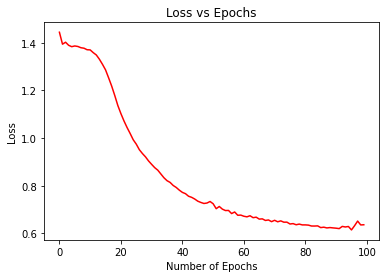

In [102]:
import matplotlib.pyplot as plt

plt.title("Loss vs Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.plot(range(len(losses)), losses, 'red')
plt.show()

In [103]:
proteins = prot_embeddings.detach().cpu().numpy()
drugs = embeddings1.detach().cpu().numpy()
diseases = embeddings2.detach().cpu().numpy()

In [104]:
save_embeddings = dict()
save_embeddings["proteins"] = proteins
save_embeddings["drugs"] = drugs
save_embeddings["diseases"] = diseases

In [105]:
with open('./embeddings.pkl', 'wb') as f:   # the whole dataset
    pickle.dump(save_embeddings, f)

In [107]:
diseases[1446]

array([-1.1852033 ,  1.2074946 , -0.68478924, -0.38683727,  0.7466029 ,
        0.7582197 ,  0.5772464 ,  0.01250559, -0.7902996 , -0.5219326 ,
       -1.6259668 , -1.2220792 , -1.6374283 , -0.19371529,  0.20221747,
       -0.0061234 ], dtype=float32)

## Getting top hits

In [113]:
with open('./final_data.pkl', 'rb') as f:
    data_dict = pickle.load(f)
data = Data.from_dict(data_dict)

In [115]:
proteins = prot_embeddings.detach().cpu()
drugs = embeddings1.detach().cpu()
diseases = embeddings2.detach().cpu()

In [132]:
data["dd_edge_index"]

tensor([[   0,    0,    0,  ..., 1445, 1447, 1447],
        [  74,  102,  113,  ..., 6107,  450,  859]])

In [153]:
output = model.decoder(drugs, diseases, data["dd_edge_index"]).detach()
output

tensor([0.7098, 0.9087, 0.8555,  ..., 0.8953, 0.7427, 0.8703])

In [154]:
covid_edges = torch.zeros((2, data["n_drug"]), dtype=int)
for i in range(data["n_drug"]):
    covid_edges[0][i] = 1446 # corresponds to sars-cov-2
    covid_edges[1][i] = int(i)
covid_edges

tensor([[1446, 1446, 1446,  ..., 1446, 1446, 1446],
        [   0,    1,    2,  ..., 6155, 6156, 6157]])

In [155]:
output = model.decoder(drugs, diseases, covid_edges).detach()
output

tensor([2.1817e-05, 1.0638e-07, 1.0981e-05,  ..., 7.9057e-05, 1.1650e-05,
        8.4606e-04])

In [156]:
pred = dict()
for i in range(data["n_drug"]): 
    pred[i] = output[i]
sorted_pred = dict(sorted(pred.items(), key=lambda item: item[1], reverse=True))

In [158]:
indices_in_order = []
for key in sorted_pred:
    indices_in_order.append(key)
    
indices_in_order[:5]

[2899, 102, 682, 5184, 6107]

In [160]:
print(indices_in_order)

[2899, 102, 682, 5184, 6107, 865, 137, 907, 3462, 2581, 1809, 462, 324, 113, 1229, 1228, 442, 105, 488, 686, 5215, 293, 122, 1698, 2496, 2634, 148, 274, 1209, 529, 864, 175, 1102, 393, 574, 942, 144, 970, 149, 162, 998, 6099, 703, 358, 386, 204, 280, 3185, 1144, 5871, 3271, 580, 727, 872, 432, 285, 5238, 3317, 713, 3693, 98, 739, 2165, 949, 427, 202, 3071, 3704, 5505, 938, 908, 834, 481, 229, 414, 94, 380, 1866, 1373, 1495, 1889, 2553, 2762, 508, 524, 169, 609, 676, 785, 160, 89, 734, 3728, 3729, 449, 1320, 1361, 1399, 2571, 2744, 948, 3095, 1987, 2790, 506, 698, 1911, 6096, 120, 981, 977, 373, 509, 659, 5258, 119, 3319, 2988, 1022, 5300, 1064, 74, 77, 547, 353, 2599, 248, 130, 1314, 584, 1180, 861, 808, 640, 1539, 722, 1309, 1327, 91, 5776, 5815, 6020, 1086, 236, 646, 781, 694, 294, 825, 181, 2780, 1326, 6040, 6064, 2875, 141, 3000, 1112, 1321, 5580, 480, 891, 492, 884, 347, 810, 3361, 3479, 673, 793, 435, 2924, 3196, 3687, 740, 5730, 452, 599, 918, 649, 614, 930, 5360, 5182, 538, 566